In [1]:
# Data Analysis and Visualization
import pandas                as pd
import numpy                 as np
from   sklearn.preprocessing import MinMaxScaler
import talib

# Visualization
from   matplotlib           import font_manager, rc
import matplotlib.pyplot    as plt
import seaborn              as sns
import mplfinance           as mpf
import plotly.graph_objects as go
import plotly.subplots      as ms

# Time Handling
import time
from   pytz     import timezone
from   datetime import date, datetime, timedelta

# HTTP Requests
from urllib.request import urlopen

# Data Sources
from   pykrx             import stock, bond
import pandas_datareader as pdr

# Configurations
import warnings

In [2]:
## 폰트 설정
import matplotlib.font_manager as font_manager
import matplotlib as mpl
# Add every font at the specified location
font_dir = ['C:/python/fonts']
for font in font_manager.findSystemFonts(fontpaths=font_dir):
    print(mpl.font_manager.FontProperties(fname=font).get_name())
    font_manager.fontManager.addfont(font)

#폰트 적용
# Set font family globally
mpl.rcParams['font.family'] = 'NanumGothic'
print(mpl.rcParams['font.family'])

# 한글 표시를 위해 폰트 지정 필수
# 기본 폰트 적용은 rcParams 설정으로
# - font.family : 기본 폰트 종류 적용
# - axes.unicode_minus : False로 설정 시 마이너스 기호로 ASCII로 한다.

mpl.rcParams["font.family"] = 'NanumGothic'
mpl.rcParams["axes.unicode_minus"]=False

plt.rcParams['axes.unicode_minus'] = False    # 마이너스 깨짐 방지
warnings.filterwarnings('ignore')             # 경고 무시


NanumGothic
SeoulNamsan
NanumGothic
Nanum Pen
NanumGothic
['NanumGothic']


In [3]:
def get_mdd_5(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2017-09-01 ~ 2022-09-01 5년간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 5년 간의 mdd 값
    """
    return get_mdd(df_stock, '2017-09-01', '2022-09-01')
def get_mdd_10(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2012-09-01 ~ 2022-09-01 10년간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 10년 간의 mdd 값
    """
    return get_mdd(df_stock, '2012-09-01', '2022-09-01')
def get_mdd_200(df_stock):
    """
    특정 종목을 DataFrame형식으로 받아 2018-10-22 ~ 2022-09-01 200주 간의 mdd를 반환한다.
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    [Returns]
    float64 : 2018-10-22 ~ 2022-09-01 200주 간의 mdd 값
    """
    return get_mdd(df_stock, '2018-10-22', '2022-09-01')
def get_corr(df_stock1, df_stock2, start, end):
    """
    특정 두 종목을 DataFrame형식으로 받아 두 종목 간의 상관계수를 반환한다.
    [Parameters]
    df_stock1 (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    df_stock2 (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    start    (str)                          : 매수일
    end      (str)                          : 매도일
    [Returns]
    float64 : 상관계수 값
    """
    df_stock1 = set_date(df_stock1, start, end)
    df_stock2 = set_date(df_stock2, start, end)
    data = pd.concat([df_stock1['close'].reset_index(drop=True), df_stock2['close'].reset_index(drop=True)], axis=1)
    daily_return = np.log(data / data.shift(1))
    corr = daily_return.corr().iloc[1,0]
    return round(corr,3)
def set_date(df_stock, buy, sell):
    """
    문자열 형식의 구매 날짜와 판매 날짜를 입력 받아 해당 기간의 데이터만을 가진 DataFrame을 반환한다.
    
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : 조회하고자 하는 데이터가 담긴 DataFrame
    buy      (str)                         : 매수일
    sell     (str)                         : 매도일
    
    [Returns]
    pandas.core.frame.DataFrame : 해당 기간의 데이터만을 가진 DataFrame
    """

    buy = datetime.strptime(buy,'%Y-%m-%d')  #매수일을 날짜 형식으로 변환
    sell = datetime.strptime(sell,'%Y-%m-%d') # 매도일을 날짜 형식으로 변환
    cond1 = df_stock['date'] >= buy # 조회하고자 하는 날짜가 매수일 이상
    cond2 = df_stock['date'] <= sell # 조회하고자 하는 날짜가 매도일 이하

    return df_stock.loc[cond1 & cond2] # 조회하고자 하는 데이터의 날짜 기준으로 매수일 이상이며 매도일 이하인 데이터 인덱싱


def get_beta(df_stock, df_index, start, end):
    """
    베타란 ? -> "금융에서 개별 주식이나 포트폴리오의 위험을 나타내는 상대적인 지표"

    특정 종목과 시장지수를 DataFrame형식으로 받아 시장지수 대비 특정 종목의 베타값을 반환한다.
    
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : 조회하고자 하는 특정종목의 DataFrame
    df_index (pandas.core.frame.DataFrame) : 조회하고자 하는 시장지수 인덱스 DataFrame
    start    (str)                         : 매수일
    end      (str)                         : 매도일
    
    [Returns]
    float64 : beta 값
    """
    
    df_stock = set_date(df_stock, start, end)
    df_index = set_date(df_index, start, end)
    
    data = pd.concat([df_stock['close'].reset_index(drop=True), df_index['close'].reset_index(drop=True)], axis=1) #조회하고자 하는 특정종목의 데이터와 조회하고자하는 시장지수 인덱스를 열로 결합
    daily_return = np.log(data / data.shift(1)) # 구해진 값을 shif 함수를 활용하여 행이 아래로 내려가면서 당일종가 / 전일종가 구하기

    cov = daily_return.cov() * 250 #개별 주식 수익률 계산
    cov_market = cov.iloc[0,1] #개별주식 수익률의 변화가 전체시장 수익률의 변화에 관련 수준
    market_var = daily_return.iloc[:,1].var() * 250  # 시장의 데이터들이 평균에서 얼마나 분산되어 있는지의 수준
    beta = cov_market / market_var   # 개별주식 수익률의 변화가 전체시장 수익률의 변화에 관련 수준 / 시장의 데이터들이 평균에서 얼마나 분산되어 있는지의 수준

    # 반환하는 값 : 구해진 베타값에서 셋째 자리에서 반올림
    return round(beta, 3)

def get_mdd(df_stock, start, end):
    """
    특정 종목을 DataFrame형식으로 받아 mdd를 반환한다.
    
    [Parameters]
    df_stock (pandas.core.frame.DataFrame) : mdd를 구하고자 하는 특정종목의 DataFrame
    start    (str)                         : 시작 날짜
    end      (str)                         : 종료 날짜
    
    [Returns]
    float64 : mdd 값
    """
    
    x_mdd = set_date(df_stock,start,end) 
    저가 = x_mdd['low'].min() #최저점
    index = x_mdd[x_mdd['low'] == x_mdd['low'].min()].index 

    
    전고점기간 = x_mdd.loc[:index[0], :] # 최저점 구하기
    전고점 = 전고점기간['high'].max() #최고점 구하기

    # MDD (최저점 - 최고점)/ 최저점 을 넷쨰자리에서 반올림
    mdd = round((저가 - 전고점) / 전고점, 4) * 100
    
    # MDD값 반환
    return mdd

In [4]:
# 데이터
# 연도별
df_sector_year = pd.read_csv(
    'C:/python/data/섹터별_연별_20000101_20220901.csv', encoding='cp949').drop(columns='Unnamed: 0') 

# 섹터별
df = pd.read_csv('C:/python/data/섹터별_20000101_20220901.csv',
                 encoding='cp949').drop(columns='Unnamed: 0') 

# 코스피 분류별
df_200 = pd.read_csv('C:/python/data/코스피200대분류별_20000101_20220901.csv',
                     encoding='cp949').drop(columns='Unnamed: 0')


In [5]:
# 코스피 200 직접 불러오기
df_kospi_200 = stock.get_index_ohlcv("20181022", "20220901", "1028").reset_index()
temp = df_kospi_200.reset_index()
temp['sector_name'] = stock.get_index_ticker_name('1028')
temp['sector_ticker'] = '1028'
df_kospi_200 = temp[['sector_ticker','sector_name','날짜','시가','종가','고가','저가','거래량','거래대금',
                     '상장시가총액']]

# 칼럼명 영어로 변환
df_kospi_200.columns = ['sector_ticker','sector_name','date','open','close','high','low','volume','volume($)',
                     'Market_Cap']

# 날짜 타입 설정
df['date'] = df['date'].astype("datetime64")
df_200['date'] = df_200['date'].astype("datetime64")
df_kospi_200['date'] = df_kospi_200['date'].astype("datetime64")
df_sector_year['date'] = df_sector_year['date'].astype("datetime64")

In [6]:
# df 섹터별 구분하여 DF 생성
코스피 = df[df['sector_name']=='코스피']
음식료품 = df[df['sector_name']=='음식료품']
섬유의복 = df[df['sector_name']=='섬유의복']
종이목재 = df[df['sector_name']=='종이목재']
화학 = df[df['sector_name']=='화학']
의약품 = df[df['sector_name']=='의약품']
비금속광물 = df[df['sector_name']=='비금속광물']
철강금속 = df[df['sector_name']=='철강금속']
기계 = df[df['sector_name']=='기계']
전기전자 = df[df['sector_name']=='전기전자']
의료정밀 = df[df['sector_name']=='의료정밀']
운수장비 = df[df['sector_name']=='운수장비']
유통업 = df[df['sector_name']=='유통업']
전기가스업 = df[df['sector_name']=='전기가스업']
건설업 = df[df['sector_name']=='건설업']
운수창고업 = df[df['sector_name']=='운수창고업']
건설업 = df[df['sector_name']=='건설업']
통신업 = df[df['sector_name']=='통신업']
금융업 = df[df['sector_name']=='금융업']
은행 = df[df['sector_name']=='은행']
증권 = df[df['sector_name']=='증권']
보험 = df[df['sector_name']=='보험']
서비스업 = df[df['sector_name']=='서비스업']
제조업 = df[df['sector_name']=='제조업']

In [7]:
# 칼럼명 리스트 선언
sector_list=['코스피', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업',
       '금융업', '은행', '증권', '보험', '서비스업', '제조업']

x_list = [코스피, 음식료품, 섬유의복, 종이목재, 화학, 의약품, 비금속광물, 철강금속, 기계,
       전기전자, 의료정밀, 운수장비, 유통업, 전기가스업, 건설업, 운수창고업, 통신업,
       금융업, 은행, 증권, 보험, 서비스업, 제조업]

time_list = [df_sector_year]

In [8]:
# df_200 섹터별 구분하여 DF 생성
커뮤니케이션서비스200 = df_200[df_200['sector_name']=='코스피 200 커뮤니케이션서비스']
건설200 = df_200[df_200['sector_name']=='코스피 200 건설']
중공업200 = df_200[df_200['sector_name']=='코스피 200 중공업']
철강소재200 = df_200[df_200['sector_name']=='코스피 200 철강/소재']
에너지화학200 = df_200[df_200['sector_name']=='코스피 200 에너지/화학']
정보기술200 = df_200[df_200['sector_name']=='코스피 200 정보기술']
금융200 = df_200[df_200['sector_name']=='코스피 200 금융']
생활소비재200 = df_200[df_200['sector_name']=='코스피 200 생활소비재']
경기소비재200 = df_200[df_200['sector_name']=='코스피 200 경기소비재']
산업재200 = df_200[df_200['sector_name']=='코스피 200 산업재']
헬스케어200 = df_200[df_200['sector_name']=='코스피 200 헬스케어']

In [9]:
# 섹터별 구분하여 DF 생성
df_name_list=[]
for i in range(len(time_list)):
    for j in range(len(sector_list)):
        df_name_list.append(time_list[i][time_list[i]['sector_name']==sector_list[j]])

In [10]:
# 섹터별 분리
df_sector_코스피=df_name_list[0]
df_sector_음식료품=df_name_list[1] 
df_sector_섬유의복=df_name_list[2] 
df_sector_종이목재=df_name_list[3] 
df_sector_화학=df_name_list[4] 
df_sector_의약품=df_name_list[5] 
df_sector_비금속광물=df_name_list[6]
df_sector_철강금속=df_name_list[7] 
df_sector_기계=df_name_list[8] 
df_sector_전기전자=df_name_list[9] 
df_sector_의료정밀=df_name_list[10]
df_sector_운수장비=df_name_list[11] 
df_sector_유통업=df_name_list[12] 
df_sector_전기가스업=df_name_list[13] 
df_sector_건설업=df_name_list[14] 
df_sector_운수창고업=df_name_list[15] 
df_sector_통신업=df_name_list[16]
df_sector_금융업=df_name_list[17] 
df_sector_은행=df_name_list[18] 
df_sector_증권=df_name_list[19] 
df_sector_보험=df_name_list[20] 
df_sector_서비스업=df_name_list[21] 
df_sector_제조업=df_name_list[22]

In [11]:
df_sector_코스피

,date,Open,High,Low,Close,Volume,Volume($),sector_name,sector_ticker
0,2003-12-31,578.50,824.26,512.30,810.71,109666469113,355362625966515,코스피,1001
23,2004-12-31,816.26,939.52,713.99,895.92,92850770285,412588138748165,코스피,1001
46,2005-12-31,896.00,1383.14,866.17,1379.37,116439734090,655074594730170,코스피,1001
69,2006-12-31,1383.32,1464.70,1192.09,1434.46,68936782766,704587507977345,코스피,1001
92,2007-12-31,1438.89,2085.45,1345.08,1897.13,89506074528,951904852427970,코스피,1001
115,2008-12-31,1891.45,1901.13,892.16,1124.47,88149063223,576927703499465,코스피,1001
138,2009-12-31,1132.87,1723.17,992.69,1682.77,122871286203,887935182728775,코스피,1001
161,2010-12-31,1681.71,2052.97,1532.68,2051.00,95595708006,1141885458029375,코스피,1001
184,2011-12-31,2063.69,2231.47,1644.11,1825.74,87732413177,1041999162203131,코스피,1001
207,2012-12-31,1831.69,2057.28,1758.99,1997.05,120646923380,1154294166644442,코스피,1001


In [12]:
# 섹터별 코스피 지수 =  코스피지수 작성 기준시점은 1980년 1월 4일. 
# 이 날 유가증권시장에 상장된 보통주 전 종목의 시가총액을 100으로 놓았을 때 오늘 현재 시가총액이 얼마나 되는지를 다음 식을 따라 구하면, 오늘의 코스피지수 값이 나온다
df_sector_year_코스피_index = (df_sector_코스피['Close'] / df_sector_코스피['Close'].iloc[0]) * 100
df_sector_year_음식료품_index = (df_sector_음식료품['Close'] / df_sector_음식료품['Close'].iloc[0]) * 100
df_sector_year_섬유의복_index = (df_sector_섬유의복['Close'] / df_sector_섬유의복['Close'].iloc[0]) * 100
df_sector_year_종이목재_index = (df_sector_종이목재['Close'] / df_sector_종이목재['Close'].iloc[0]) * 100
df_sector_year_화학_index = (df_sector_화학['Close'] / df_sector_화학['Close'].iloc[0]) * 100
df_sector_year_의약품_index = (df_sector_의약품['Close'] / df_sector_의약품['Close'].iloc[0]) * 100
df_sector_year_비금속광물_index = (df_sector_비금속광물['Close'] / df_sector_비금속광물['Close'].iloc[0]) * 100
df_sector_year_철강금속_index = (df_sector_철강금속['Close'] / df_sector_철강금속['Close'].iloc[0]) * 100
df_sector_year_기계_index = (df_sector_기계['Close'] / df_sector_기계['Close'].iloc[0]) * 100
df_sector_year_전기전자_index = (df_sector_전기전자['Close'] / df_sector_전기전자['Close'].iloc[0]) * 100
df_sector_year_의료정밀_index = (df_sector_의료정밀['Close'] / df_sector_의료정밀['Close'].iloc[0]) * 100
df_sector_year_운수장비_index = (df_sector_운수장비['Close'] / df_sector_운수장비['Close'].iloc[0]) * 100
df_sector_year_유통업_index = (df_sector_유통업['Close'] / df_sector_유통업['Close'].iloc[0]) * 100
df_sector_year_전기가스업_index = (df_sector_전기가스업['Close'] / df_sector_전기가스업['Close'].iloc[0]) * 100
df_sector_year_건설업_index = (df_sector_건설업['Close'] / df_sector_건설업['Close'].iloc[0]) * 100
df_sector_year_운수창고업_index = (df_sector_운수창고업['Close'] / df_sector_운수창고업['Close'].iloc[0]) * 100
df_sector_year_통신업_index = (df_sector_통신업['Close'] / df_sector_통신업['Close'].iloc[0]) * 100
df_sector_year_금융업_index = (df_sector_금융업['Close'] / df_sector_금융업['Close'].iloc[0]) * 100
df_sector_year_은행_index = (df_sector_은행['Close'] / df_sector_은행['Close'].iloc[0]) * 100
df_sector_year_증권_index = (df_sector_증권['Close'] / df_sector_증권['Close'].iloc[0]) * 100
df_sector_year_보험_index = (df_sector_보험['Close'] / df_sector_보험['Close'].iloc[0]) * 100
df_sector_year_서비스업_index = (df_sector_서비스업['Close'] / df_sector_서비스업['Close'].iloc[0]) * 100
df_sector_year_제조업_index = (df_sector_제조업['Close'] / df_sector_제조업['Close'].iloc[0]) * 100


In [13]:
# 전처리
산업 = df[df['date']=='2022-01-26'][1:]
전체_산업_시총 = 산업['Market_Cap'].sum()
sector_name_list = 산업['sector_name'].unique()
각_산업_시총_비중 = {}

for sec in sector_name_list:
    tmp = (산업[산업['sector_name']==sec]['Market_Cap']).item()
    각_산업_시총_비중[sec] = tmp/전체_산업_시총*100
    
각_산업_시총_비중 = pd.DataFrame(list(각_산업_시총_비중.items()),
                   columns=['산업','비중'])
각_산업_시총_비중 = 각_산업_시총_비중.sort_values(by='비중',ascending=False)
ratio = 각_산업_시총_비중['비중']
labels = 각_산업_시총_비중['산업']

In [14]:
sector_list=['코스피', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업',
       '금융업', '은행', '증권', '보험', '서비스업', '제조업']

x_list = [코스피, 음식료품, 섬유의복, 종이목재, 화학, 의약품, 비금속광물, 철강금속, 기계,
       전기전자, 의료정밀, 운수장비, 유통업, 전기가스업, 건설업, 운수창고업, 통신업,
       금융업, 은행, 증권, 보험, 서비스업, 제조업]

# 베타 구하기
beta = []
for x in x_list:
    beta.append(get_beta(코스피,x,'2022-01-01','2022-09-01'))

tmp={}
for i in range(len(x_list)):
    tmp[sector_list[i]] = beta[i]
    
tmp = pd.DataFrame(list(tmp.items()),
                   columns=['sector_list','beta'])
beta = tmp.sort_values(by='beta',ascending=False)
beta = beta.reset_index().drop('index',axis=1)
beta = beta.fillna(0)

In [15]:
corr = {}
x = x_list[0]
for j in range(len(x_list)):
    y = x_list[j]
    corr[sector_list[j]] = get_corr(x,y,'2022-01-01','2022-09-01')
corr = pd.DataFrame(list(corr.items()),columns=['sector_list',sector_list[0]])

for i in range(1,len(x_list)):
    tmp = {}
    x = x_list[i]
    for j in range(len(x_list)):
        y = x_list[j]
        tmp[sector_list[j]] = get_corr(x,y,'2022-01-01','2022-09-01')
    tmp = pd.DataFrame(list(tmp.items()),columns=['sector_list',sector_list[i]])
    corr = pd.merge(corr,tmp)  
corr = corr.set_index('sector_list')

In [16]:
경제섹터 = df_200[df_200['date']=='2022-09-01']
전체_경제섹터_시총 = 경제섹터['Market_Cap'].sum()
경제섹터_list = 경제섹터['sector_name'].unique()
각_경제섹터_시총_비중 = {}

for sec in 경제섹터_list:
    tmp = (경제섹터[경제섹터['sector_name']==sec]['Market_Cap']).item()
    각_경제섹터_시총_비중[sec] = tmp/전체_경제섹터_시총*100
    
각_경제섹터_시총_비중 = pd.DataFrame(list(각_경제섹터_시총_비중.items()),
                   columns=['경제섹터','비중'])
각_경제섹터_시총_비중 = 각_경제섹터_시총_비중.sort_values(by='비중',ascending=False)
ratio_200 = 각_경제섹터_시총_비중['비중']
labels_200 = 각_경제섹터_시총_비중['경제섹터']

In [17]:
sec_200 = [커뮤니케이션서비스200,건설200,중공업200,철강소재200,에너지화학200,정보기술200,금융200,생활소비재200,경기소비재200,산업재200,헬스케어200]
sec_200_name = ['코스피 200 커뮤니케이션서비스', '코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재',
       '코스피 200 에너지/화학', '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재',
       '코스피 200 경기소비재', '코스피 200 산업재', '코스피 200 헬스케어']

sec_200_corr_dict = {}
temp_list = []
for idx, i in enumerate(sec_200):
    for j in sec_200:
        temp_list.append(get_corr(i,j,'2022-01-01','2022-09-01'))
    sec_200_corr_dict[sec_200_name[idx]] = temp_list
    temp_list = []

상관계수_200 = pd.DataFrame(sec_200_corr_dict, index = sec_200_name)
상관계수_200.reset_index().rename(columns={'index':'상대섹터'})

,상대섹터,코스피 200 커뮤니케이션서비스,코스피 200 건설,코스피 200 중공업,코스피 200 철강/소재,코스피 200 에너지/화학,코스피 200 정보기술,코스피 200 금융,코스피 200 생활소비재,코스피 200 경기소비재,코스피 200 산업재,코스피 200 헬스케어
0,코스피 200 커뮤니케이션서비스,1.000,0.484,0.385,0.464,0.634,0.725,0.525,0.556,0.565,0.617,0.648
1,코스피 200 건설,0.484,1.000,0.766,0.726,0.724,0.574,0.588,0.581,0.593,0.775,0.465
2,코스피 200 중공업,0.385,0.766,1.000,0.669,0.677,0.451,0.482,0.455,0.496,0.738,0.381
3,코스피 200 철강/소재,0.464,0.726,0.669,1.000,0.699,0.557,0.667,0.517,0.569,0.712,0.402
4,코스피 200 에너지/화학,0.634,0.724,0.677,0.699,1.000,0.761,0.613,0.594,0.645,0.795,0.546
5,코스피 200 정보기술,0.725,0.574,0.451,0.557,0.761,1.000,0.544,0.593,0.662,0.666,0.631
6,코스피 200 금융,0.525,0.588,0.482,0.667,0.613,0.544,1.000,0.481,0.546,0.640,0.368
7,코스피 200 생활소비재,0.556,0.581,0.455,0.517,0.594,0.593,0.481,1.000,0.643,0.680,0.555
8,코스피 200 경기소비재,0.565,0.593,0.496,0.569,0.645,0.662,0.546,0.643,1.000,0.646,0.493
9,코스피 200 산업재,0.617,0.775,0.738,0.712,0.795,0.666,0.640,0.680,0.646,1.000,0.578


In [18]:
sec = [코스피, 음식료품, 섬유의복, 종이목재, 화학, 의약품, 비금속광물, 철강금속, 기계,
       전기전자, 의료정밀, 운수장비, 유통업, 전기가스업, 건설업, 운수창고업, 통신업,
       금융업, 은행, 증권, 보험, 서비스업, 제조업]
sec_name_5 = ['코스피_5', '음식료품_5', '섬유의복_5', '종이목재_5', '화학_5', '의약품_5', '비금속광물_5', '철강금속_5', '기계_5',
       '전기전자_5', '의료정밀_5', '운수장비_5', '유통업_5', '전기가스업_5', '건설업_5', '운수창고업_5', '통신업_5',
       '금융업_5', '은행_5', '증권_5', '보험_5', '서비스업_5', '제조업_5']

sec_5_dict = {}

for idx, name in enumerate(sec):
    sec_5_dict[sec_name_5[idx]] = round(get_mdd_5(name),3)

sec_name_10 = ['코스피_10', '음식료품_10', '섬유의복_10', '종이목재_10', '화학_10', '의약품_10', '비금속광물_10', '철강금속_10', '기계_10',
       '전기전자_10', '의료정밀_10', '운수장비_10', '유통업_10', '전기가스업_10', '건설업_10', '운수창고업_10', '통신업_10',
       '금융업_10', '은행_10', '증권_10', '보험_10', '서비스업_10', '제조업_10']

sec_10_dict = {}

for idx, name in enumerate(sec):
    sec_10_dict[sec_name_10[idx]] = round(get_mdd_10(name),3)

df_mdd_5 = pd.DataFrame(data = sec_5_dict.values(), index = sec_5_dict.keys(), columns = ['MDD_5'])
df_mdd_10 = pd.DataFrame(data = sec_10_dict.values(), index = sec_10_dict.keys(), columns = ['MDD_10'])
df_mdd_5_modified = df_mdd_5 + 44.79
df_mdd_5_modified = df_mdd_5_modified.sort_values(by=['MDD_5'])

sec_200 = [커뮤니케이션서비스200,건설200,중공업200,철강소재200,에너지화학200,정보기술200,금융200,생활소비재200,경기소비재200,산업재200,헬스케어200]
sec_200_name = ['코스피 200 커뮤니케이션서비스', '코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재',
       '코스피 200 에너지/화학', '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재',
       '코스피 200 경기소비재', '코스피 200 산업재', '코스피 200 헬스케어']

sec_200_dict={}
for idx, name in enumerate(sec_200):
    sec_200_dict[sec_200_name[idx]] = round(get_mdd_200(name),3)
sec_200_dict['코스피 200'] = round(get_mdd_200(df_kospi_200),3)
df_mdd_200 = pd.DataFrame(data = sec_200_dict.values(), index = sec_200_dict.keys(), columns = ['MDD_200'])
df_mdd_200_modified = df_mdd_200 + 36.18
df_mdd_200_modified = df_mdd_200_modified.sort_values(by=['MDD_200'])

df_mdd_10_modified = df_mdd_10 + 44.79


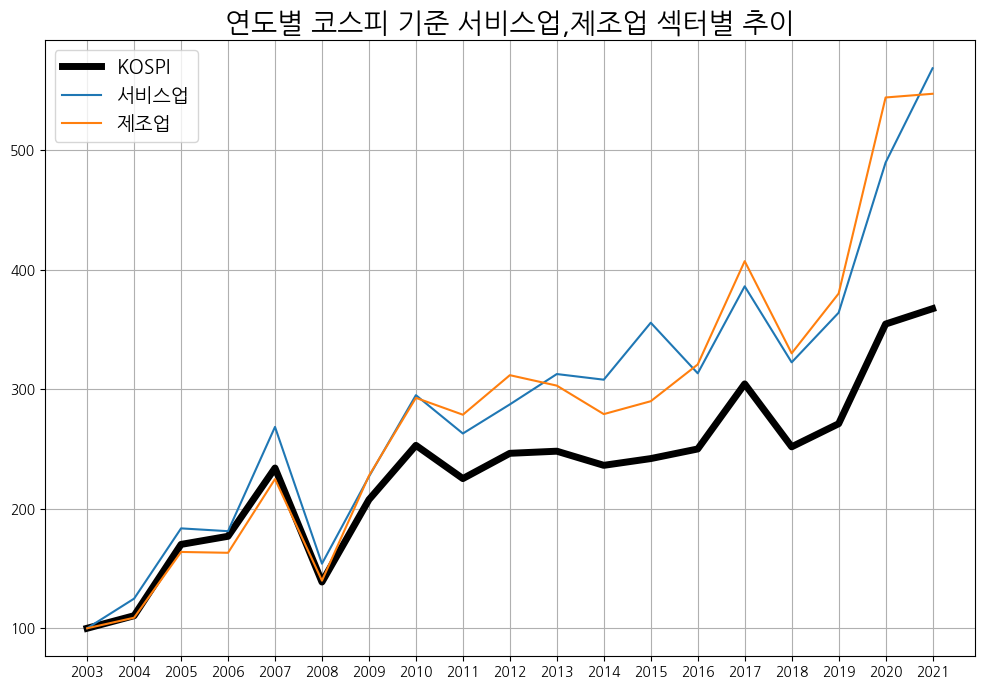

In [19]:
# Visualization: 연도별 코스피 기준 섹터별 추이

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
xtick_label_position = list(
    range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position, df_sector_year_코스피_index,
        linewidth=5, color='k', label="KOSPI")
ax.plot(xtick_label_position, df_sector_year_서비스업_index, label="서비스업")
ax.plot(xtick_label_position, df_sector_year_제조업_index, label="제조업")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 서비스업,제조업 섹터별 추이",fontsize = 20)
plt.show()


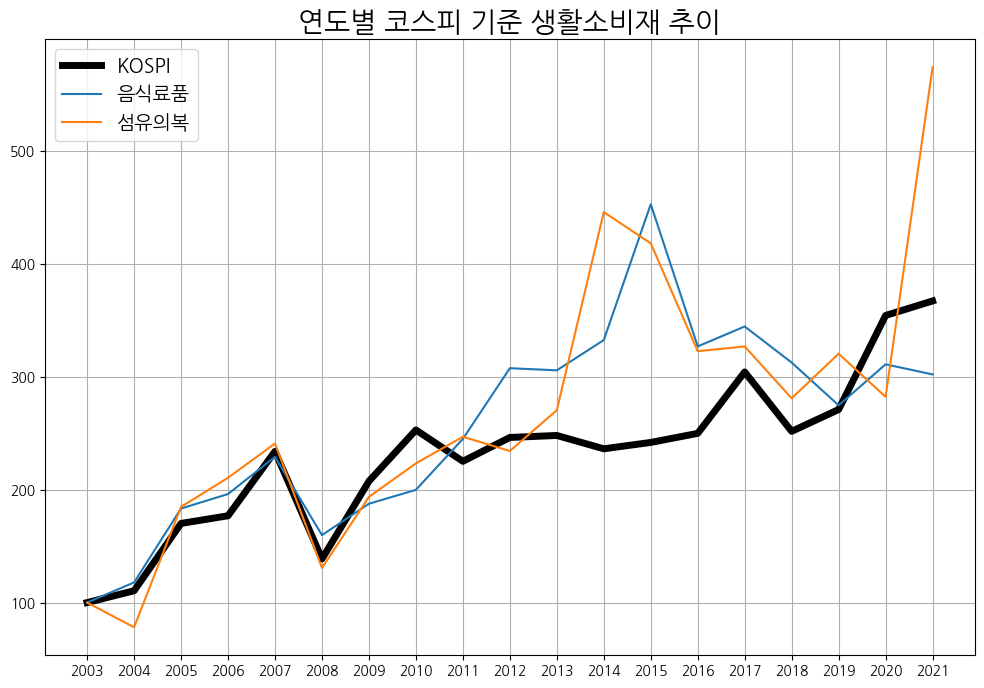

In [20]:
# Visualization: 연도별 코스피 기준 생활소비재 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")
ax.plot(xtick_label_position,df_sector_year_음식료품_index,label = "음식료품")
ax.plot(xtick_label_position,df_sector_year_섬유의복_index,label = "섬유의복")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 생활소비재 추이",fontsize = 20)
plt.show()


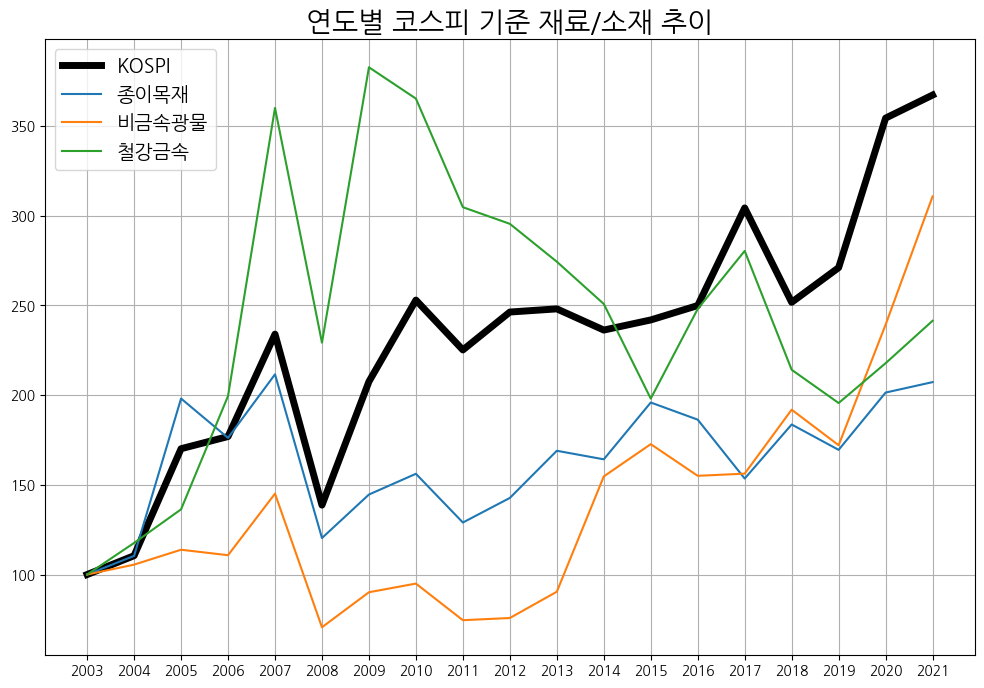

In [21]:
# Visualization: 연도별 코스피 기준 재료/소재 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")
ax.plot(xtick_label_position,df_sector_year_종이목재_index,label = "종이목재")
ax.plot(xtick_label_position,df_sector_year_비금속광물_index,label = "비금속광물")
ax.plot(xtick_label_position,df_sector_year_철강금속_index,label = "철강금속")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 재료/소재 추이",fontsize = 20)
plt.show()

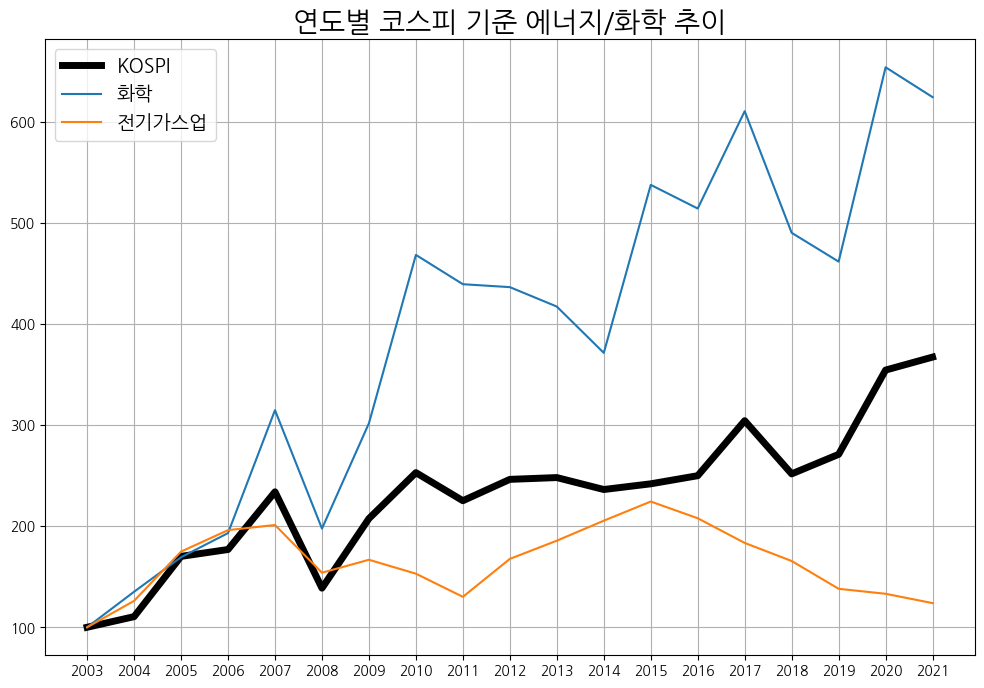

In [22]:
# Visualization: 연도별 코스피 기준 에너지/화학 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")
ax.plot(xtick_label_position,df_sector_year_화학_index,label = "화학")
ax.plot(xtick_label_position,df_sector_year_전기가스업_index,label = "전기가스업")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 에너지/화학 추이",fontsize = 20)
plt.show()


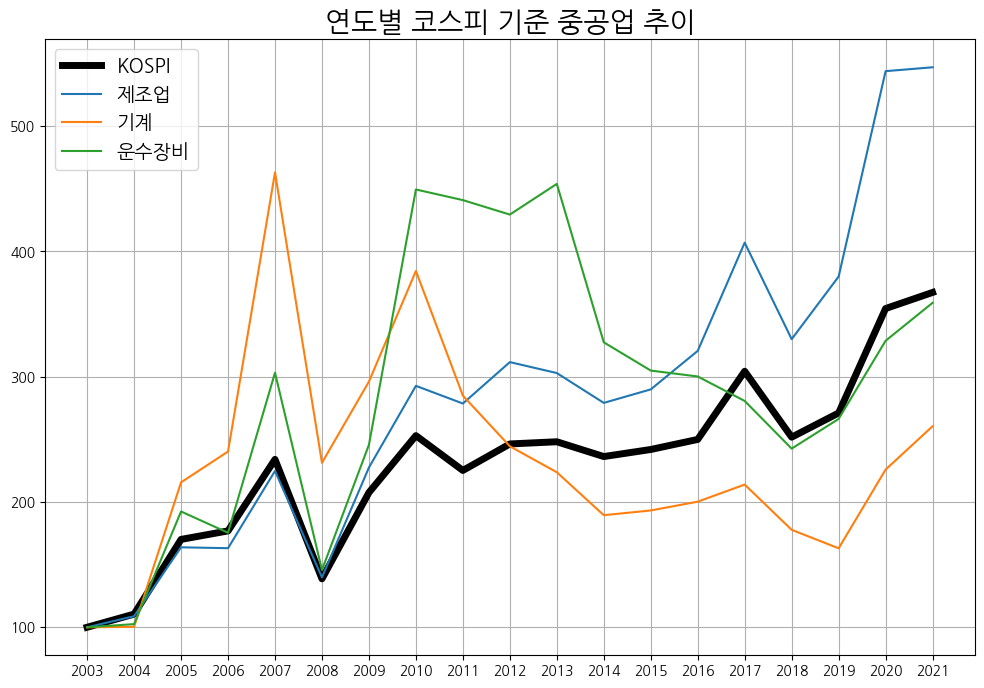

In [23]:
# Visualization: 연도별 코스피 기준 중공업 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")
ax.plot(xtick_label_position,df_sector_year_제조업_index,label = "제조업")
ax.plot(xtick_label_position,df_sector_year_기계_index,label = "기계")
ax.plot(xtick_label_position,df_sector_year_운수장비_index,label = "운수장비")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 중공업 추이",fontsize = 20)
plt.show()

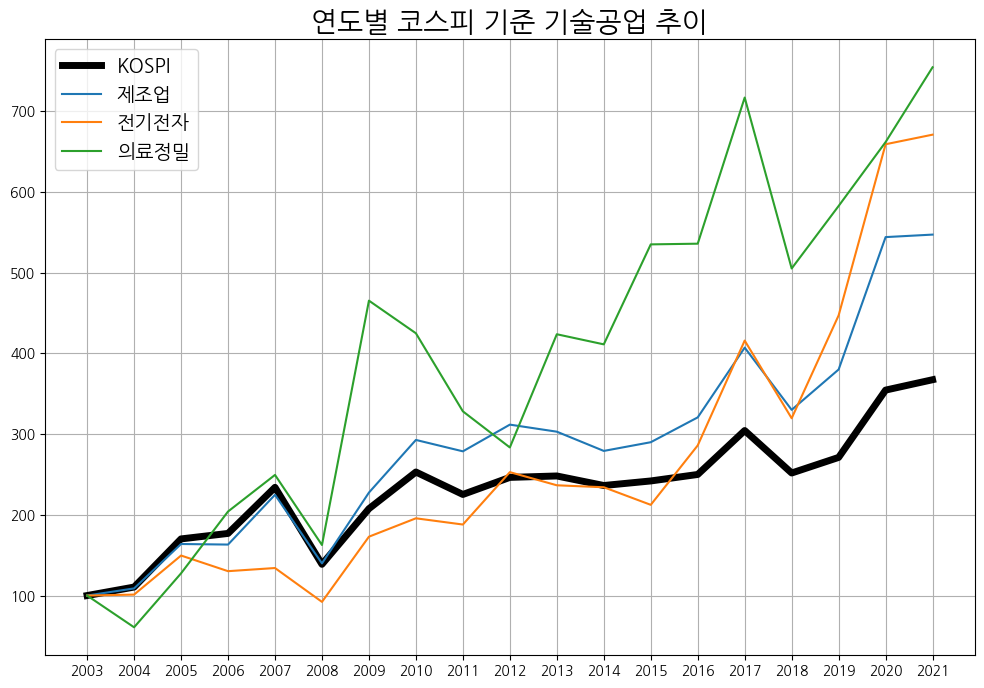

In [24]:
# Visualization: 연도별 코스피 기준 기술공업 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")
ax.plot(xtick_label_position,df_sector_year_제조업_index,label = "제조업")
ax.plot(xtick_label_position,df_sector_year_전기전자_index,label = "전기전자")
ax.plot(xtick_label_position,df_sector_year_의료정밀_index,label = "의료정밀")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 기술공업 추이",fontsize = 20)
plt.show()


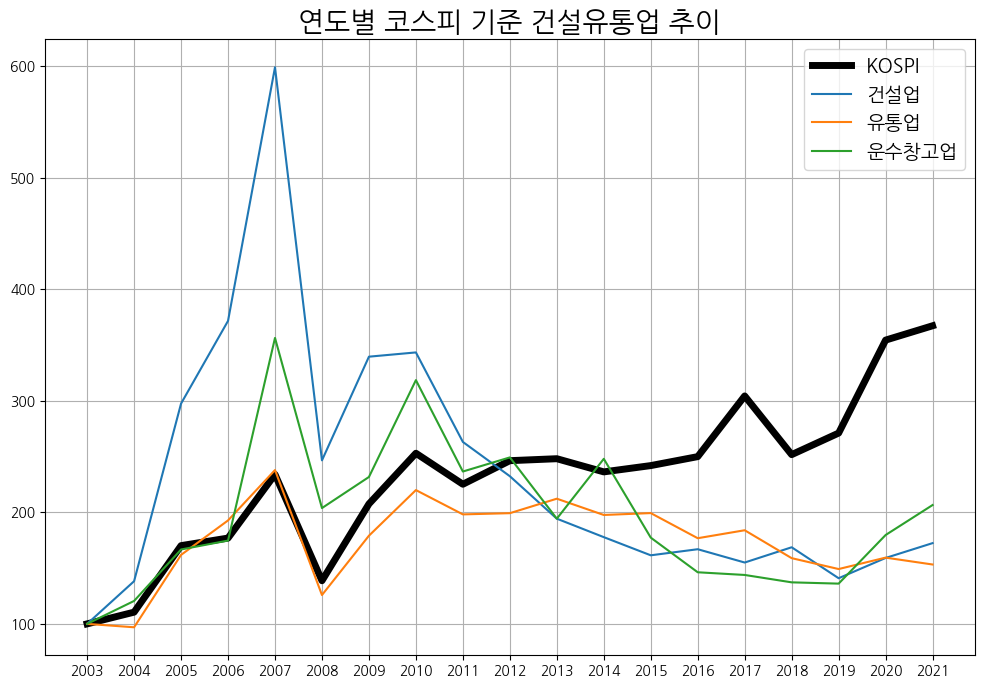

In [25]:
# Visualization: 연도별 코스피 기준 건설유통업 추이

fig  =  plt.figure(figsize = (12,8))
ax  =  fig.add_subplot(1,1,1)
xtick_label_position  = list(range(len(df_sector_year['date'].dt.year.unique())))

ax.set_xticks(xtick_label_position)
ax.set_xticklabels(df_sector_year['date'].dt.year.unique())
ax.plot(xtick_label_position,df_sector_year_코스피_index,linewidth=5, color='k', label = "KOSPI")

ax.plot(xtick_label_position,df_sector_year_건설업_index,label = "건설업")
ax.plot(xtick_label_position,df_sector_year_유통업_index,label = "유통업")
ax.plot(xtick_label_position,df_sector_year_운수창고업_index,label = "운수창고업")

plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.grid(True)
plt.legend(fontsize = 14)
plt.title("연도별 코스피 기준 건설유통업 추이",fontsize = 20)
plt.show()